# Xarray reference

## Loading and prepping data from WHOI's "CMIP" server

The goal of this script is to demonstrate – and provide a reference for – how to load and pre-process gridded climate data from WHOI's servers. We'll start by [opening](#Opening-data) and [plotting](#Plotting-data) some temperature data and perform some common pre-processing steps, including [spatial averaging](#Spatial-averaging), [removing the seasonal cycle](#Seasonal-cycle), [interpolation and resampling](#Interpolation-and-resampling), [detrending](#Detrending), [computing correlations](#Correlation), and [regridding](#Regridding-data). These examples are not necessarily the "best" (e.g., most efficient) way to do things and are intended as a starting point (the 2-dimenstional dataset we're working with is small enough that it doesn't matter too much if we do things inefficiently).

Whenever possible, we've attempted to use built-in functions from [xarray](https://xarray.dev/), a Python package useful for working with gridded climate data and netcdf files. I think of it as a high-level "wrapper" for lower-level packages like ```numpy``` and ```pandas```. While the core of a ```xarray.DataArray``` object is a ```numpy.array```, the ```xarray``` object includes dimension names and additional metadata. This tends to make code easier to interpret: for example, to average over latitudes in a ```numpy``` array, you have to keep track of which array dimension corresponds to latitude – e.g., ```data.mean(axis=2)```, if latitude is the 2$^{nd}$ dimension – whereas in ```xarray``` you don't: ```data.mean(dim="latitude")```.  

For a more complete tutorial on the ```xarray``` package, I highly recommend the developers' official [45-minute tutorial](https://tutorial.xarray.dev/overview/xarray-in-45-min.html).  

## Imports

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import cmocean
from matplotlib.dates import DateFormatter
import seaborn as sns
import glob
import cftime
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import os.path

## set plotting style
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## initialize random number generator
rng = np.random.default_rng()

## Open the data

```{admonition} To-do
Specify the path to the file server in the following code cell.
```

In [5]:
## To-do: update path to WHOI file server on your machine
## On Mac, the default location is "/Volumes"
server_path = pathlib.Path("/Volumes")

### Specify file paths

In [6]:
#### Path to ERA5 T2m data
t2m_path_on_server = pathlib.Path(
    "cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature"
)

#### Path to ERA5 SLP data
slp_path_on_server = pathlib.Path(
    "cmip6/data/era5/reanalysis/single-levels/monthly-means/mean_sea_level_pressure"
)

#### Path to MIROC6 SST data
sst_path_on_server = pathlib.Path(
    "cmip6/data/cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Omon/tos/gn/1"
)

## append these relative filepaths to the server filepath
t2m_path = pathlib.Path(server_path, t2m_path_on_server)
slp_path = pathlib.Path(server_path, slp_path_on_server)
sst_path = pathlib.Path(server_path, sst_path_on_server)

## Opening data
We're going to work with a "reanalysis" product located on the CMIP6 archive. As a reminder from lecture, a reanalysis is a hybrid of model output and observations. Observations (e.g., of rainfall, temperature, or ocean salinity) are sparse (& irregular) in time in space. The purpose of the reanalysis is to fill in the gaps, creating a nice "gridded" dataset which *is* regular in time and space.

Note: for the ERA5 reanalysis, each year of data has a separate file. We'll print out the names of the first 4 files.

In [9]:
## List the first few files in the 2m-temperature folder
file_list = list(t2m_path.glob("*.nc"))
print(np.sort(file_list)[:4])

[PosixPath('/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1979_2m_temperature.nc')
 PosixPath('/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1980_2m_temperature.nc')
 PosixPath('/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1981_2m_temperature.nc')
 PosixPath('/Volumes/cmip6/data/era5/reanalysis/single-levels/monthly-means/2m_temperature/1982_2m_temperature.nc')]


To open the dataset, use ```xr.open_dataset``` (single file) or ```xr.open_mfdataset``` (multiple files).

In [10]:
## Load a single file using xarray
T2m_1980 = xr.open_dataset(pathlib.Path(t2m_path, "1980_2m_temperature.nc"))
T2m_1980.load()
# loads into memory

## open the first 3 files (but don't load to memory)
T2m = xr.open_mfdataset(file_list[:3])

To subset data, use the ```.isel``` / ```.sel``` functions. We'll write a function which trims data to the North Atlantic region.

In [11]:
## select data for Jan 1., two different ways
print(
    np.allclose(
        T2m_1980["t2m"].isel(time=0).values,
        T2m_1980["t2m"].sel(time="1980-01-01").values,
    )
)


def trim_to_north_atl(x):
    """trims data to the North Atlantic region"""

    ## lon/lat boundaries for N. Atlantic
    lon_range = [260, 360]
    lat_range = [70, 3]

    ## trim the data
    x_trimmed = x.sel(longitude=slice(*lon_range), latitude=slice(*lat_range))

    return x_trimmed

True


If we only care about a subset of the data (i.e., not the whole globe), it can be helpful to subset it *while* loading. To do this, pass a subsetting function to ```xr.open_mfdataset```:

In [12]:
## Load trimmed data
T2m_trimmed = xr.open_mfdataset(file_list[:3], preprocess=trim_to_north_atl).compute()

## Compare size to original data
print(f"Shape of raw data:     {T2m['t2m'].shape}")
print(f"Shape of trimmed data: {T2m_trimmed['t2m'].shape}")

Shape of raw data:     (36, 721, 1440)
Shape of trimmed data: (36, 269, 400)


## Plotting data

### Plot setup and gridlines

First, let's define a function which draws a blank map (don't worry about the details for now).

In [13]:
## First, a generic plot setup function
def plot_setup(ax, lon_range, lat_range, xticks, yticks, scale):
    """
    Create map background for plotting spatial data.
    Arguments:
        - ax: Matplotlib object containing everything in the plot.
            (I think of it as the plot "canvas")
        - lon_range/lat_range: 2-element arrays, representing plot boundaries
        - xticks/yticks: location for lon/lat labels
        - scale: number which controls linewidth and fontsize

    Returns a modified 'ax' object.
    """

    ## specify transparency/linewidths
    grid_alpha = 0.1 * scale
    grid_linewidth = 0.5 * scale
    coastline_linewidth = 0.3 * scale
    label_size = 8 * scale

    ## crop map and plot coastlines
    ax.set_extent([*lon_range, *lat_range], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=coastline_linewidth)

    ## plot grid
    gl = ax.gridlines(
        draw_labels=True,
        linestyle="--",
        alpha=grid_alpha,
        linewidth=grid_linewidth,
        color="k",
        zorder=1.05,
    )

    ## add tick labels
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": label_size}
    gl.ylabel_style = {"size": label_size}
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xlocator = mticker.FixedLocator(xticks)

    return ax, gl


## Next, a function to plot the North Atlantic
def plot_setup_north_atl(ax, scale=1):
    """Create map background for plotting spatial data.
    Returns modified 'ax' object."""

    ## specify range and ticklabels for plot
    lon_range = [-100, 0]
    lat_range = [3, 70]
    xticks = [-80, -60, -40, -20, 0]
    yticks = [20, 40, 60]

    ax, gl = plot_setup(ax, lon_range, lat_range, xticks, yticks, scale)

    return ax, gl

Next, plot a sample of the temperature dataset. 

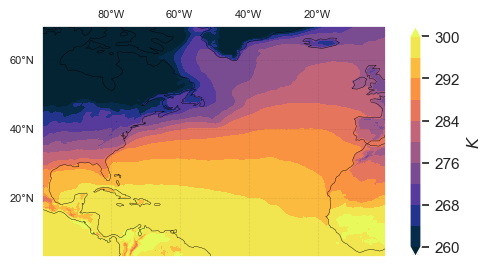

In [14]:
## Create a figure object (can contain multiple "Axes" object)
fig = plt.figure(figsize=(6, 3))

## add Axes object (blank canvas for our plot)
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax, gl = plot_setup_north_atl(ax)

## Let's plot T2m data for Jan 1, 1980
t2m_plot = ax.contourf(
    T2m_1980.longitude,
    T2m_1980.latitude,
    T2m_1980["t2m"].isel(time=0),
    levels=np.arange(260, 304, 4),  # contour levels to plot
    cmap="cmo.thermal",  # colormap (see https://matplotlib.org/cmocean/)
    extend="both",  # includes values outside of contour bounds,
    transform=ccrs.PlateCarree(),
)

## add a colorbar
cb = fig.colorbar(t2m_plot, orientation="vertical", label=r"$K$")

plt.show()

### Plotting in the Pacific

#### Plotting functions
Let's start from scratch for this example: define a function to set up a plot with the given projection and lon/lat range (```plot_setup_simple```). Then define a wrapper function which sets up a plot with the given projection *in the North Pacific*.
Note we have to specify the projection keyword (e.g., ccrs.PlateCarree or ccrs.Orthographic) when creating an Axes object with the ```fig.add_subplot``` function. When plotting data on regular lon/lat grids, we also have to pass ```ccrs.PlateCarree``` as an argument to ```ax.set_extent``` and to the contour plotting function, ```ax.contourf```. Note the map projection type passted to ```fig.add_subplot``` may change (shown below) but we always pass ```ccrs.PlateCarree``` to the ```ax.set_extent``` and ```ax.contourf``` functions (I don't know why this is the case, but it seems to work :).

In [15]:
def plot_setup_simple(fig, projection, lon_range, lat_range):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines()

    return ax


def plot_setup_pacific(fig, projection):
    """Plot Pacific region"""
    return plot_setup_simple(fig, projection, lon_range=[120, 240], lat_range=[30, 70])

#### Make plots for two projection types, PlateCarree and Orthographic

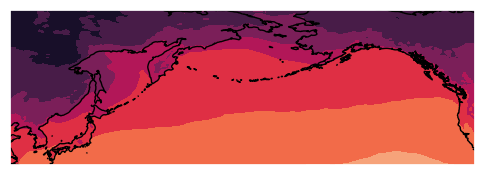

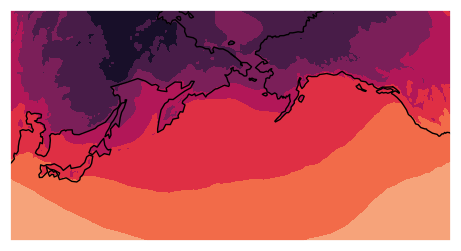

In [16]:
## define some map projections
## for a full list, see https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
proj_PC = ccrs.PlateCarree(central_longitude=180)
proj_ortho = ccrs.Orthographic(central_longitude=180, central_latitude=50)

## Plot data with each projection
for proj in [proj_PC, proj_ortho]:

    ## make blank figure
    fig = plt.figure(figsize=(6, 3))

    ## plot pacific background
    ax = plot_setup_pacific(fig, proj)

    ## plot data
    ax.contourf(
        T2m_1980.longitude,
        T2m_1980.latitude,
        T2m_1980["t2m"].isel(time=0),
        transform=ccrs.PlateCarree(),
    )

    plt.show()

### Highlighting specific contours

#### Plot the data (and highlight the $280 K$ contour)

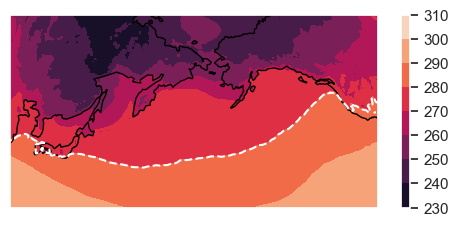

In [17]:
## make blank figure
fig = plt.figure(figsize=(6, 2.5))

## plot pacific background
ax = plot_setup_pacific(
    fig, projection=ccrs.Orthographic(central_longitude=180, central_latitude=50)
)

## plot the data
# plot_data = ax.contourf(t2m.longitude, t2m.latitude, t2m, transform=ccrs.PlateCarree())
plot_data = ax.contourf(
    T2m_1980.longitude,
    T2m_1980.latitude,
    T2m_1980["t2m"].isel(time=0),
    transform=ccrs.PlateCarree(),
)

## Add a colorbar
cb = fig.colorbar(plot_data)

##### Highlight a specified contour value #####

## specify which value to highlight
contour_value = 280

## Create list of contour levels to pass to the plotting function.
## We'll pad the contour value we want to plot with -/+ a big number:
## we have to add these "pad" values because the plotting function
## (ax.contour) will throw an error if we only pass only one value.
## The pad value is chosen to be outside of the range of the data values
## so isn't plotted.
pad_value = 1e10
levels = [-pad_value, contour_value, pad_value]

## call the plotting function
ax.contour(
    T2m_1980.longitude,
    T2m_1980.latitude,
    T2m_1980["t2m"].isel(time=0),
    transform=ccrs.PlateCarree(),
    levels=levels,
    colors="white",
    linestyles="dashed",
)

################################################

plt.show()

## Spatial averaging

Next, write a function to spatially average the data. This is slightly more involved than just averaging over all elements in the array: we need to compute a weighted average, with the weights given by the cosine of the latitude . The reason is that we're averaging on the surface of a sphere, and need to account for the fact that grid cells get smaller as you go closer to the poles (see [below](#Explanation-of-cos(latitude)-weighting) for a more detailed explanation).

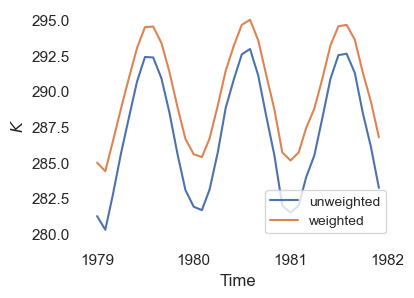

In [18]:
def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.latitude)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["longitude", "latitude"])

    return avg


## "naive" unweighted average over longitude and latitudes
avg_unweighted = T2m_trimmed["t2m"].mean(["latitude", "longitude"])

## (correct) weighted average
avg_weighted = spatial_avg(T2m_trimmed["t2m"])

## compare results:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(avg_unweighted.time, avg_unweighted, label="unweighted")
ax.plot(avg_weighted.time, avg_weighted, label="weighted")

## label plot
ax.legend(prop={"size": 10})
ax.set_xlabel("Time")
ax.set_ylabel(r"$K$")
ax.set_xticks(ax.get_xticks()[::3])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.show()

### Explanation of cos(latitude) weighting
Not every element in our array represents an equal surface area of the earth: on a "regular" longitude-latitude grid (where the longitude and latitude spacing is constant) the area of gridcells decreases as you move away from the equator to the poles. Denoting longitude and latitude as $\theta$ and $\phi$, and longitude and latitude spacing as $\delta\theta$ and $\delta\phi$, the area of each gridcell is given by $\delta A ~= R^2\cos(\phi)\delta\phi\delta\theta$, where $R$ is the radius of the earth. The weighted average of a variable $f$ on the sphere is then given by:
\begin{align}
    \overline{f} &= \frac{\sum f~\delta A}{\sum \delta A} = \frac{\sum f~R^2\cos\left(\phi\right)~\delta\phi~\delta\theta}{\sum R^2\cos\left(\phi\right)~\delta\phi~\delta\theta} = \frac{R^2 ~\delta\phi~\delta\theta \sum f~\cos\left(\phi\right)}{R^2~\delta\phi~\delta\theta \sum \cos(\phi)} = \frac{\sum f\cos(\phi)}{\sum\cos(\phi)},
\end{align}
where we use the fact that $R^2$, $\delta\theta$, and $\delta\phi$ are constant (and can be pulled out of the summation). Therefore, to compute $\overline{f}$, we need to compute a *weighted* average, where the weights are the cosine of the latitude.

## Seasonal cycle

Use ```groupby``` to group data by month (and apply functions to each month separately). Below, we'll compute the mean temperature for each season and subtract it from the data to obtain anomalies.

In [19]:
seasonal_cyc = avg_weighted.groupby("time.month").mean()
anomalies = avg_weighted.groupby("time.month") - seasonal_cyc

Plot results

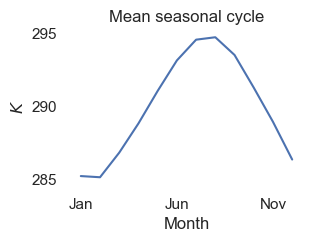

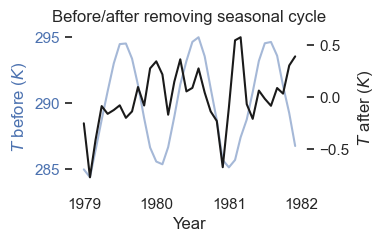

In [20]:
## plot seasonal cycle
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(seasonal_cyc.month, seasonal_cyc)
ax.set_xticks([1, 6, 11], labels=["Jan", "Jun", "Nov"])
ax.set_yticks(ticks=[285, 290, 295])
ax.set_ylabel(r"$K$")
ax.set_xlabel("Month")
ax.set_title("Mean seasonal cycle")
plt.show()


## Plot anomalies
fig, ax = plt.subplots(figsize=(3, 2))

## plot raw data
p = ax.plot(avg_weighted.time, avg_weighted, label="w/ seasonal cycle", alpha=0.5)
ax.set_ylabel(r"$T$ before ($K$)", color=p[0].get_color())
ax.set_yticks(ticks=[285, 290, 295], labels=[285, 290, 295], color=p[0].get_color())

## plot after removing mean seasonal cycle
ax_anom = ax.twinx()
ax_anom.plot(anomalies.time, anomalies, label="w/o seasonal cycle", c="k")
ax_anom.set_ylabel(r"$T$ after ($K$)")

## Label plot
ax.set_xticks(ax.get_xticks()[::3])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_title("Before/after removing seasonal cycle")
ax.set_xlabel("Year")

plt.show()

Note we can compute the seasonal cycle at every gridpoint separately:

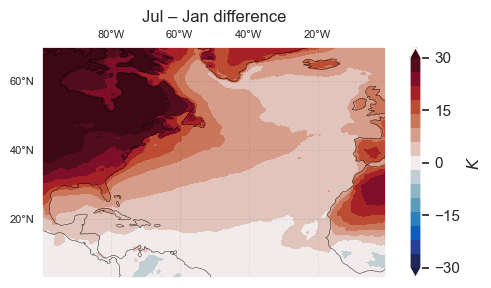

In [21]:
## compute seasonal cycle, and plot at diff. b/n july and jan
seasonal_cyc_spatial = T2m_trimmed["t2m"].groupby("time.month").mean()
jul_jan_diff = seasonal_cyc_spatial.sel(month=7) - seasonal_cyc_spatial.sel(month=1)

## Create a figure object (can contain multiple "Axes" object)
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax, gl = plot_setup_north_atl(ax)

## Plot data
t2m_plot = ax.contourf(
    jul_jan_diff.longitude,
    jul_jan_diff.latitude,
    jul_jan_diff,
    levels=np.arange(-30, 34, 4),
    cmap="cmo.balance",
    extend="both",
)

## add a colorbar and label
cb = fig.colorbar(
    t2m_plot, orientation="vertical", label=r"$K$", ticks=np.arange(-30, 45, 15)
)
ax.set_title("Jul – Jan difference")

plt.show()

Check that the order of averaging doesn't matter:

In [22]:
##  to spatial dataset
print(np.allclose(spatial_avg(seasonal_cyc_spatial), seasonal_cyc))

True


## Interpolation and resampling

### Averaging in time

Below, let's downsample from monthly data to 3-month averages, grouped into the following months: Dec-Jan-Feb (DJF), Mar-Apr-May (MAM), Jun-Jul-Aug (JJA), and Sep-Oct-Nov (SON).

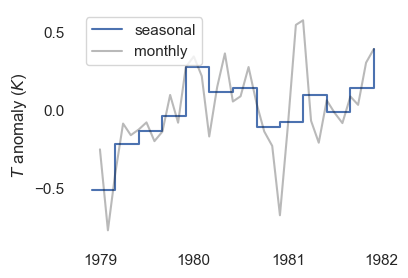

In [23]:
## Resample to quarterly (3-month) averages, where
## the first quarter starts in December ("QS-DEC"),
## and each point is labeled by the first month in the quarter
anomalies_seasonal = anomalies.resample({"time": "QS-DEC"}).mean()

## To extract the Dec-Jan-Feb season:
fig, ax = plt.subplots(figsize=(4, 3))

## plot data
ax.step(anomalies_seasonal.time, anomalies_seasonal, where="post", label="seasonal")
ax.plot(anomalies.time, anomalies, c="k", alpha=0.3, label="monthly")

## label plot
ax.set_ylabel(r"$T$ anomaly ($K$)")
ax.set_yticks([-0.5, 0.0, 0.5])
ax.set_xticks(ax.get_xticks()[::3])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend()

plt.show()

Next, downsample to annual data two different ways. Note that the resulting time axis differs for each method: one is labeled with a ```datetime``` object representing the first day in the year, while the other is labeled by an integer representing the year.

In [24]:
## annual mean, 2 different ways
anomalies_annual0 = anomalies.resample({"time": "YS-JAN"}).mean()
anomalies_annual1 = anomalies.groupby("time.year").mean()
print(np.allclose(anomalies_annual0, anomalies_annual1))

True


### Resampling in space
```xarray```'s ```interp``` function can be used to resample in space:

In [25]:
## Downsample by averaging in space
lat_coarse = T2m_trimmed.latitude[::4]
lon_coarse = T2m_trimmed.longitude[::4]

## Do the downsampling (linear interpolation is default)
T2m_coarse = T2m_trimmed.interp({"longitude": lon_coarse, "latitude": lat_coarse})

print(f"Original shape:     {T2m_trimmed['t2m'].shape}")
print(f"After downsampling: {T2m_coarse['t2m'].shape}")

Original shape:     (36, 269, 400)
After downsampling: (36, 68, 100)


## Detrending

To illustrate detrending, let's load in a longer timeseries

In [26]:
## define a preprocessing function
def preprocess(data):
    """pre-process data before loading it:
    1. Downsample in space
    2. only get DJF months
    """
    ## 1. Downsample in space
    data_ = data.interp({"longitude": lon_coarse, "latitude": lat_coarse}).compute()

    ## 2. Find indices of winter season
    month = data_.time.dt.month
    is_winter = (month == 12) | (month <= 2)

    ## select winter season
    data_ = data_.sel(time=is_winter)

    return data_


def djf_avg(data):
    """function to get Dec-Jan-Feb average"""

    ## first, resample from monthly to seasonal
    data_ = data.resample({"time": "QS-DEC"}).mean()

    ## next, select DJF season
    is_winter = data_.time.dt.month == 12
    data_ = data_.sel(time=is_winter)

    ## for convenience, replace "time" index with "year":
    ## label with year for Jan, (so Dec-'78,Jan-'79,Feb-'79 -> 1979)
    year = data_.time.dt.year.values + 1
    data_["time"] = year
    data_ = data_.rename({"time": "year"})

    return data_


## load prepped data
T2m_long = xr.open_mfdataset(file_list, preprocess=preprocess)

## Get DJF average
T2m_djf = djf_avg(T2m_long)

Next, write a function to compute a trend along a given dimension

In [27]:
def get_trend(data, dim="year"):
    """Get linear trend for an xr.dataarray along specified dimension"""

    ## Get coefficients for best fit
    polyfit_coefs = data.polyfit(dim=dim, deg=1)["polyfit_coefficients"]

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend

Compute the trend and remove it from data to obtain a "detrended" version.

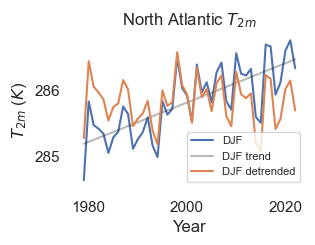

In [28]:
## compute the trend
T2m_trend = get_trend(T2m_djf["t2m"])

## Get detrended version
T2m_detrended = T2m_djf["t2m"] - T2m_trend

## compute spatial averages
T2m_trend_avg = spatial_avg(T2m_trend)
T2m_detrended_avg = spatial_avg(T2m_detrended)
T2m_djf_avg = spatial_avg(T2m_djf["t2m"])


## plot result
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(T2m_djf_avg.year, T2m_djf_avg, label="DJF")
ax.plot(T2m_trend_avg.year, T2m_trend_avg, label="DJF trend", c="k", alpha=0.3)
ax.plot(
    T2m_detrended_avg.year,
    T2m_detrended_avg + T2m_trend_avg.mean(),
    label="DJF detrended",
)
ax.set_yticks([285, 286])
ax.set_xticks([1980, 2000, 2020])
ax.legend(prop={"size": 8})
ax.set_title(r"North Atlantic $T_{2m}$")
ax.set_xlabel("Year")
ax.set_ylabel(r"$T_{2m}$ ($K$)")
plt.show()

## Correlation

Load in sea level pressure from ERA5 and detrend it.

In [31]:
## Get list of SLP files
slp_file_list = list(slp_path.glob("*.nc"))

## Open SLP over N. Atlantic
slp = xr.open_mfdataset(slp_file_list, preprocess=preprocess)["msl"]

## convert from Pa to hPa (1 hPa = 100 Pa)
slp *= 1 / 100

## Get DJF average
slp_djf = djf_avg(slp)

## detrend
slp_detrended = slp_djf - get_trend(slp_djf)

### Compute point-wise correlation between SLP and $T_{2m}$

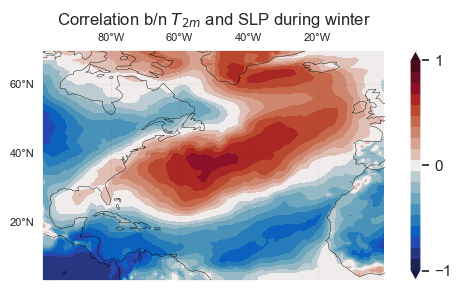

In [32]:
def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def make_correlation_plot(correlation):

    ## Plot results
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    ax, gl = plot_setup_north_atl(ax)

    ## Plot data
    corr_plot = ax.contourf(
        correlation.longitude,
        correlation.latitude,
        correlation,
        levels=make_cb_range(1, 0.1),
        cmap="cmo.balance",
        extend="both",
    )

    ## add a colorbar and label
    cb = fig.colorbar(corr_plot, orientation="vertical", ticks=[-1, 0, 1])

    return fig, ax


## compute correlation
slp_T2m_corr = xr.corr(slp_detrended, T2m_detrended, dim="year")

## plot results
fig, ax = make_correlation_plot(slp_T2m_corr)
ax.set_title(r"Correlation b/n $T_{2m}$ and SLP during winter")
plt.show()

### Correlation between a single point the rest of the grid

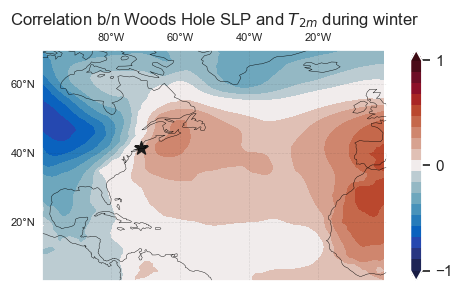

In [33]:
## get SLP near Woods Hole
T2m_woodshole = T2m_detrended.interp(latitude=41.5, longitude=288.5)

## get correlation between Woods Hole T2m and North Atlantic SLP
T2mWH_slp_corr = xr.corr(T2m_woodshole, slp_detrended, dim="year")

fig, ax = make_correlation_plot(T2mWH_slp_corr)
ax.scatter(288.5, 41.5, marker="*", c="k", s=100)
ax.set_title(r"Correlation b/n Woods Hole SLP and $T_{2m}$ during winter")
plt.show()

## Regridding data

Next, we're going to load data on a non-regular grid (tripolar, in this case). Specifically, we'll look at sea surface temperature (SST) from the MIROC6 model's historical simulation. We'll show how to plot the data on it's native grid and how to regrid it to a regular lon/lat grid.

Start by importing ```xesmf``` package for regridding

In [34]:
import xesmf as xe

First, load the data

In [37]:
## specify filename
sst_fname = "tos_Omon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc"
sst_path_to_file = pathlib.Path(sst_path, sst_fname)

## open the data and trim in time
sst_miroc6 = xr.open_dataset(sst_path_to_file)
sst_miroc6 = sst_miroc6.isel(time=slice(-36, None)).compute()

Next, regrid to a "regular" lon/lat grid

In [38]:
## should we use custom grid?
use_custom_grid = True

if use_custom_grid:
    # create regular lon/lat grid
    grid = xr.DataArray(
        data=None,
        coords={"longitude": np.arange(0, 360), "latitude": np.arange(-90, 91)},
        dims=["longitude", "latitude"],
    )

else:
    # use ERA5 grid
    grid = T2m_detrended.isel(year=0)

## do the regridding
regridder = xe.Regridder(ds_in=sst_miroc6, ds_out=grid, method="bilinear")
sst_miroc6_regridded = regridder(sst_miroc6)

/Users/theo/research/12860_tutorial/envs/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/Users/theo/research/12860_tutorial/envs/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Plot comparison of data on native and regular grids

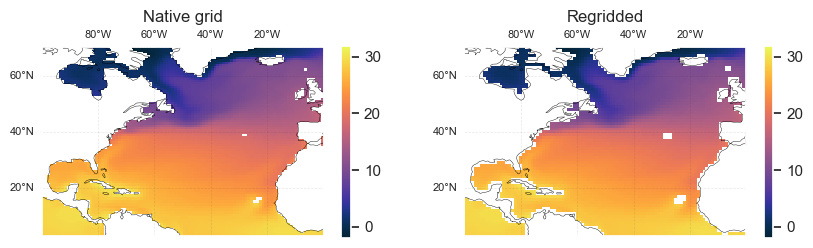

In [39]:
## set up the plot
fig = plt.figure(figsize=(10, 2.5))

## canvas for plot on native grid
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax, gl = plot_setup_north_atl(ax)

## canvas for plot with regridded data
ax_regridded = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax_regridded, gl_regridded = plot_setup_north_atl(ax_regridded)

## Plot data on native grid
ax.set_title("Native grid")
sst_plot = ax.pcolormesh(
    sst_miroc6.longitude,
    sst_miroc6.latitude,
    sst_miroc6["tos"].mean("time"),
    cmap="cmo.thermal",
    vmin=-2,
    vmax=32,
)
cb = fig.colorbar(sst_plot)

## Plot regridded data
ax_regridded.set_title("Regridded")
xx, yy = np.meshgrid(sst_miroc6_regridded.longitude, sst_miroc6_regridded.latitude)
sst_plot_regridded = ax_regridded.pcolormesh(
    xx,
    yy,
    sst_miroc6_regridded["tos"].mean("time"),
    cmap="cmo.thermal",
    vmin=-2,
    vmax=32,
)
cb = fig.colorbar(sst_plot_regridded, ticks=[0, 10, 20, 30])

plt.show()